[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/gibranfp/CursoAprendizajeProfundo/blob/2024-1/notebooks/3b_traductor_GRU.ipynb)

# Traducción Automatica

---
Curso: Aprendizaje Profundo.

Profesor: Gibran Fuentes Pineda.

Ayudantes: Fernando Nava y Rodrigo del Moral

---

En esta libreta resolveremos la tarea de traducción automática utilizando redes neuronales recurrentes.

## 1 Preparación

In [1]:
!python -m spacy download en
#!python -m spacy download de
!python -m spacy download fr

2023-11-01 18:08:56.840855: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-01 18:08:56.840918: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-01 18:08:56.840958: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-01 18:08:56.852165: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-01 18:08:59.287803: W tensorflow/c

### 1.1 Bibliotecas

In [2]:
# Manejar archivos
import io

# Herramientas de torchtext
import torchtext
from torchtext.utils import download_from_url, extract_archive
from torchtext.data.utils import get_tokenizer
from collections import Counter, OrderedDict
from torchtext.vocab import vocab

# Dataset y Dataloader
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader

#Redes Neuronales
import torch
import torch.nn as nn

#Graficar
import matplotlib.pyplot as plt

import random


## 2 Datos

Se utilizó el conjunto de datos Multi30k que se encuentra en https://github.com/multi30k/dataset

### 2.1 Conjunto de datos

In [3]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'
train_urls = ('train.fr.gz', 'train.en.gz')
val_urls = ('val.fr.gz', 'val.en.gz')
test_urls = ('test_2016_flickr.fr.gz', 'test_2016_flickr.en.gz')

In [4]:
train_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in train_urls]
val_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in val_urls]
test_filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in test_urls]

100%|██████████| 604k/604k [00:00<00:00, 6.33MB/s]
100%|██████████| 569k/569k [00:00<00:00, 5.83MB/s]
100%|██████████| 23.0k/23.0k [00:00<00:00, 2.72MB/s]
100%|██████████| 21.6k/21.6k [00:00<00:00, 4.49MB/s]
100%|██████████| 22.3k/22.3k [00:00<00:00, 2.95MB/s]
100%|██████████| 21.1k/21.1k [00:00<00:00, 2.67MB/s]


In [5]:
print(train_filepaths)
print(val_filepaths)
print(test_filepaths)

['/content/.data/train.fr', '/content/.data/train.en']
['/content/.data/val.fr', '/content/.data/val.en']
['/content/.data/test_2016_flickr.fr', '/content/.data/test_2016_flickr.en']


In [6]:
with io.open(train_filepaths[0], encoding="utf8") as f:
  for string_ in f:
    ej_fr = string_
    print(ej_fr)
    break

Deux jeunes hommes blancs sont dehors près de buissons.



In [7]:
# Para spacy el lenguaje
tok_fr = get_tokenizer('spacy',language='fr_core_news_sm')
tok_fr(ej_fr)

['Deux',
 'jeunes',
 'hommes',
 'blancs',
 'sont',
 'dehors',
 'près',
 'de',
 'buissons',
 '.',
 '\n']

In [8]:
with io.open(train_filepaths[1], encoding="utf8") as f:
  for string_ in f:
    ej_en = string_
    print(ej_en)
    break

Two young, White males are outside near many bushes.



In [9]:
tok_en = get_tokenizer('spacy', language='en_core_web_sm')
tok_en(ej_en)

['Two',
 'young',
 ',',
 'White',
 'males',
 'are',
 'outside',
 'near',
 'many',
 'bushes',
 '.',
 '\n']

In [10]:
counter = Counter()
with io.open(train_filepaths[0], encoding="utf8") as f:
  for string_ in f:
    counter.update(tok_en(string_))
counter

Counter({'Deux': 3173,
         'jeunes': 656,
         'hommes': 1632,
         'blancs': 207,
         'sont': 1941,
         'dehors': 599,
         'près': 798,
         'de': 13902,
         'buissons': 23,
         '.': 27686,
         '\n': 29000,
         'Plusieurs': 303,
         'en': 9833,
         'casque': 277,
         'font': 364,
         'fonctionner': 7,
         'un': 16670,
         'système': 3,
         'poulies': 2,
         'géant': 18,
         'Une': 6187,
         'petite': 620,
         'fille': 1758,
         'grimpe': 35,
         'dans': 8027,
         'une': 11736,
         'maisonnette': 2,
         'bois': 344,
         'Un': 14003,
         'homme': 7659,
         'chemise': 662,
         'bleue': 501,
         'se': 1983,
         'tient': 904,
         'sur': 7937,
         'échelle': 53,
         'pour': 1297,
         'nettoyer': 22,
         'fenêtre': 133,
         'aux': 399,
         'fourneaux': 5,
         'préparent': 57,
         'à': 530

In [11]:
sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
sorted_by_freq_tuples

[('\n', 29000),
 ('.', 27686),
 ('un', 16670),
 ('Un', 14003),
 ('de', 13902),
 ('une', 11736),
 ('en', 9833),
 ('dans', 8027),
 ('sur', 7937),
 ('homme', 7659),
 ('et', 7426),
 ('avec', 7175),
 ('Une', 6187),
 ('des', 5794),
 ('la', 5380),
 ('à', 5300),
 (',', 4800),
 ('femme', 4450),
 ("d'un", 3332),
 ('-', 3297),
 ('le', 3239),
 ('est', 3175),
 ('Deux', 3173),
 ("d'une", 2301),
 ('debout', 1992),
 ('se', 1983),
 ('personnes', 1950),
 ('sont', 1941),
 ('jeune', 1813),
 ('devant', 1790),
 ('tandis', 1780),
 ('au', 1775),
 ('fille', 1758),
 ('du', 1685),
 ('groupe', 1677),
 ('garçon', 1674),
 ('assis', 1664),
 ('chien', 1644),
 ('hommes', 1632),
 ('Des', 1612),
 ('son', 1481),
 ('rue', 1457),
 ('les', 1457),
 ('rouge', 1454),
 ('noir', 1359),
 ('portant', 1341),
 ('shirt', 1322),
 ('blanc', 1317),
 ('pour', 1297),
 ('T', 1223),
 ('gens', 1126),
 ('train', 1091),
 ('bleu', 1055),
 ('femmes', 1038),
 ('fait', 1027),
 ('enfant', 951),
 ('qui', 949),
 ('sa', 948),
 ('côté', 923),
 ('tient'

In [12]:
sorted_by_freq_tuples[0]

('\n', 29000)

In [13]:
ordered_dict = OrderedDict(sorted_by_freq_tuples)
ordered_dict

OrderedDict([('\n', 29000),
             ('.', 27686),
             ('un', 16670),
             ('Un', 14003),
             ('de', 13902),
             ('une', 11736),
             ('en', 9833),
             ('dans', 8027),
             ('sur', 7937),
             ('homme', 7659),
             ('et', 7426),
             ('avec', 7175),
             ('Une', 6187),
             ('des', 5794),
             ('la', 5380),
             ('à', 5300),
             (',', 4800),
             ('femme', 4450),
             ("d'un", 3332),
             ('-', 3297),
             ('le', 3239),
             ('est', 3175),
             ('Deux', 3173),
             ("d'une", 2301),
             ('debout', 1992),
             ('se', 1983),
             ('personnes', 1950),
             ('sont', 1941),
             ('jeune', 1813),
             ('devant', 1790),
             ('tandis', 1780),
             ('au', 1775),
             ('fille', 1758),
             ('du', 1685),
             ('groupe', 1677),


In [14]:
ordered_dict['écoute']

31

### 2.2 Dataset

In [15]:
# Función para generar el vocabulario:
def build_vocab(filepath, tokenizer):
  counter = Counter()
  with io.open(filepath, encoding="utf8") as f:
    for string_ in f:
      counter.update(tokenizer(string_)[:-1])
  sorted_by_freq_tuples = sorted(counter.items(), key=lambda x: x[1], reverse=True)
  ordered_dict = OrderedDict(sorted_by_freq_tuples)
  vocabulary = vocab(ordered_dict, specials=[ '<pad>', '<sos>', '<eos>','<unk>'], special_first=True)
  vocabulary.set_default_index(vocabulary['<unk>'])
  return vocabulary

In [16]:
class Multi30k_Data(Dataset):
  def __init__(self, url_base, fr_tokenizer, en_tokenizer, data='Train'):

    if data == 'Train':
      data_urls = ('train.fr.gz', 'train.en.gz')
    if data == 'Val':
      data_urls = ('val.fr.gz', 'val.en.gz')
    if data == 'Test':
      data_urls = ('test_2016_flickr.fr.gz', 'test_2016_flickr.en.gz')

    filepaths = [extract_archive(download_from_url(url_base + url))[0] for url in data_urls]

    self.sentence_fr = [fr_tokenizer(sentence)[:-1] for sentence in io.open(filepaths[0], encoding="utf8")]
    self.sentence_en = [en_tokenizer(sentence)[:-1] for sentence in io.open(filepaths[1], encoding="utf8")]

    # Crea un Vocabulario para cada idioma:
    self.fr_vocab = build_vocab(filepaths[0], fr_tokenizer)
    self.en_vocab = build_vocab(filepaths[1], en_tokenizer)

  def __len__(self):
    #print('len sent en: ', len(self.sentence_en))
    return len(self.sentence_fr)


  def __getitem__(self, i):
    text_fr = self.sentence_fr[i]
    text_en = self.sentence_en[i]

    # Token to index:
    index_fr = [self.fr_vocab[token] for token in text_fr]
    # Insert <sos> and <eos> in deutsch:
    index_fr.insert(0, self.fr_vocab['<sos>'])
    index_fr.append(self.fr_vocab['<eos>'])
    index_fr = torch.tensor(index_fr)

    index_en = [self.en_vocab[token] for token in text_en]
    # Insert <sos> and <eos> in english:
    index_en.insert(0, self.en_vocab['<sos>'])
    index_en.append(self.en_vocab['<eos>'])
    index_en = torch.tensor(index_en)

    return (index_en, index_fr)




In [17]:
url_base = 'https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw/'

# Tokenizer:
# Usando tokenizador spacy del lenguaje Alemán e Ingles:
tok_fr = get_tokenizer('spacy',language='fr_core_news_sm')
tok_en = get_tokenizer('spacy', language='en_core_web_sm')

In [18]:
ds_train = Multi30k_Data(url_base, fr_tokenizer=tok_fr, en_tokenizer=tok_en, data='Train')
ds_val = Multi30k_Data(url_base, fr_tokenizer=tok_fr, en_tokenizer=tok_en, data='Val')
ds_test = Multi30k_Data(url_base, fr_tokenizer=tok_fr, en_tokenizer=tok_en, data='Test')

In [19]:
ds_train[0]

(tensor([   1,   19,   25,   15, 1165,  804,   17,   57,   84,  334, 1329,    5,
            2]),
 tensor([   1,   25,   84,   33,  224,   30,   90,   74,    8, 1192,    4,    2]))

In [20]:
pred_de = [ds_train.en_vocab.get_itos()[i] for i in ds_train[0][0]]
print(pred_de)

['<sos>', 'Two', 'young', ',', 'White', 'males', 'are', 'outside', 'near', 'many', 'bushes', '.', '<eos>']


In [21]:
#trn_ds[0][1]
pred_en = [ds_train.fr_vocab.get_itos()[i] for i in ds_train[0][1]]
print(pred_en)

['<sos>', 'Deux', 'jeunes', 'hommes', 'blancs', 'sont', 'dehors', 'près', 'de', 'buissons', '.', '<eos>']


### 2.3 Dataloader

index_en_inp: son las frases en el idioma destino que le pasaremos como entrada al decoder (con \<sos> como primer token y sin \<eos>)


index_en_label: son las frases en el idioma destino que usaremos para calcular la pérdida (con \<eos> como finalizador de oración y sin \<sos>)

In [22]:
SRC_PAD_IDX = ds_train.fr_vocab['<pad>']
TGT_PAD_IDX = ds_train.en_vocab['<pad>']

class MyCollate:
  def __call__(self, batch):
    # Idioma fuente:
    src = [item[0][1:] for item in batch]
    src = pad_sequence(src, batch_first=False, padding_value=SRC_PAD_IDX)

    #Idioma a Traducir:
    # Inputs without <eos>
    index_en_inp = [item[1][:-1] for item in batch]
    index_en_inp = pad_sequence(index_en_inp, batch_first=False, padding_value=TGT_PAD_IDX)

    # Inputs without <sos>
    index_en_label = [item[1][1:] for item in batch]
    index_en_label = pad_sequence(index_en_label, batch_first=False, padding_value=TGT_PAD_IDX)

    return (src, index_en_inp, index_en_label)

In [23]:
len(ds_train)

29000

In [24]:
# Instanciar el dataloader train:
dl_trn = DataLoader(dataset=ds_train,
                batch_size=64,
                shuffle=True,
                drop_last=True,
                collate_fn=MyCollate())

# Instanciar el dataloader train:
dl_val = DataLoader(dataset=ds_val,
                batch_size=64,
                shuffle=True,
                drop_last=True,
                collate_fn=MyCollate())

# Instanciar el dataloader train:
dl_test = DataLoader(dataset=ds_test,
                batch_size=64,
                shuffle=False,
                collate_fn=MyCollate())

In [25]:
src, inp_test, label_test = next(iter(dl_trn))

In [26]:
print(src.shape)
print(src.T[0])
print(ds_train.en_vocab.lookup_tokens(src.T[0].tolist()))

torch.Size([23, 64])
tensor([   6,   12, 2887,    7, 4512,   79,    4,  268, 1394, 8954,    7,    4,
        2702,    5,    2,    0,    0,    0,    0,    0,    0,    0,    0])
['A', 'man', 'bows', 'in', 'prayer', 'over', 'a', 'very', 'ornate', 'coffin', 'in', 'a', 'cathedral', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [27]:
print(inp_test.T[0])
print(ds_train.fr_vocab.lookup_tokens(inp_test.T[0].tolist()))

tensor([   1,    7,   13,   75, 5704,    9, 3060,   12,    5, 9569, 9570,   11,
           6, 2792,    4,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
['<sos>', 'Un', 'homme', "s'", 'incline', 'en', 'priant', 'sur', 'un', 'somptueux', 'cercueil', 'dans', 'une', 'cathédrale', '.', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [28]:
print(label_test.T[0])
print(ds_train.fr_vocab.lookup_tokens(label_test.T[0].tolist()))

tensor([   7,   13,   75, 5704,    9, 3060,   12,    5, 9569, 9570,   11,    6,
        2792,    4,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0])
['Un', 'homme', "s'", 'incline', 'en', 'priant', 'sur', 'un', 'somptueux', 'cercueil', 'dans', 'une', 'cathédrale', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## 3. Modelo Seq2Seq usando GRU

<img src="https://pytorch.org/tutorials/_images/seq2seq.png">

Imagen tomada de tutorial de https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html


In [29]:
# def init_RNN(module):
#     if type(module) == nn.Linear:
#          nn.init.xavier_uniform_(module.weight)
#     if type(module) == nn.GRU:
#         for param in module._flat_weights_names:
#             if "weight" in param:
#                 nn.init.xavier_uniform_(module._parameters[param])

class RNNEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size, num_hiddens, num_layers, dropout=dropout)
        self.hid_dim = num_hiddens
        self.n_layers = num_layers
        #self.apply(init_RNN)

    def forward(self, X):
        # X shape: (num_steps, batch_size)
        embs = self.embedding(X)
        # embs shape: (num_steps, batch_size, embed_size)
        output, state = self.rnn(embs)
        # rnn_outputs shape: (num_steps, batch size, hid dim)
        # state shape: (num_layers, batch_size, num_hiddens)
        return output, state


In [30]:
class RNNDecoder(nn.Module):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size+num_hiddens, num_hiddens,
                           num_layers, dropout=dropout)
        self.linear = nn.Linear(num_hiddens, vocab_size)
        self.hid_dim = num_hiddens
        self.n_layers = num_layers

        self.output_dim = vocab_size
        #self.apply(init_RNN)

    def init_state(self, enc_output):
        #se queda con el output del último paso de tiempo
        return enc_output[-1]

    def forward(self, X, context, hidden):
        # X shape: (batch_size)
        # context shape: (batch_size, num_hiddens)
        # hidden shape: (n layers, batch_size, num_hiddens)

        input = X.unsqueeze(0)
        context = context.unsqueeze(0)
        #input shape: (1,batch_size)
        #context shape: (1, batch_size, num_hiddens)

        embs = self.embedding(input)
        # embs shape: (1, batch_size, embed_size)

        # Concatena el token de entrada con el contexto
        embs_and_context = torch.cat((embs, context), -1)
        #embs_and_context shape: (1, batch size, embed_size + num_hiddens)

        #Genera las salidas de la RNN
        rnn_outputs, state = self.rnn(embs_and_context, hidden)
        # rnn_outputs shape: (1, batch size, hid dim)
        # state shape: (num_layers, batch_size, num_hiddens)

        #Genera las probabilidades de cada token en el vocabulario
        outputs = self.linear(rnn_outputs.squeeze(0))

        # outputs shape: (batch_size, vocab_size)
        return outputs, state

### Teacher Forcing

<img src="https://sooftware.io/static/43c1417fedd352e3d13e64f0a4ceec5b/e46c1/teacher_forcing.png">

Imagen tomada de tutorial de pytorch

In [31]:
class Seq2Seq(nn.Module):
  def __init__(self, encoder, decoder, device):
    super().__init__()

    self.encoder = encoder
    self.decoder = decoder
    self.device = device

  def forward(self, src, trg):

    #src = [src len, batch size]
    #trg = [trg len, batch size]

    # Probability of use teacher forcing
    teacher_forcing_ratio = 0.5

    batch_size = trg.shape[1]
    trg_len = trg.shape[0]
    trg_vocab_size = self.decoder.output_dim

    #tensor to store decoder outputs
    outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

    #last hidden state of the encoder is used as the initial hidden state of the decoder
    enc_outputs, enc_hidden = self.encoder(src)

    #first input to the decoder is the  tokens
    input = trg[0,:]

    context = self.decoder.init_state(enc_outputs)

    for t in range(1, trg_len):

        #insert input token embedding, previous hidden and context
        dec_output, dec_hidden = self.decoder(input, context, enc_hidden)

        #place predictions in a tensor holding predictions for each token
        outputs[t] = dec_output

        #decide if we are going to use teacher forcing or not
        teacher_force = random.random() < teacher_forcing_ratio

        #get the highest predicted token from our predictions
        top1 = dec_output.argmax(1)

        #if teacher forcing, use actual next token as next input
        #if not, use predicted token
        input = trg[t] if teacher_force else top1

    return outputs


## 4. Entrenamiento

In [32]:
def train(model, iterator, optimizer, criterion, clip):

  model.train()

  epoch_loss = 0

  for i, batch in enumerate(iterator):
    src, tgt_input, tgt_out = batch
    src, tgt_input, tgt_out = src.to(device), tgt_input.to(device), tgt_out.to(device)
    #src: son las frases en el idioma origen que le pasaremos como entrada al encoder
    #src.shape : [src len, batch size]
    #tgt_input: son las frases en el idioma destino que le pasaremos como entrada al decoder.
    #tgt_out: son las frases en el idioma destino que usaremos para calcular la pérdida.
    #tgt.shape : [trg len, batch size]

    optimizer.zero_grad()
    output = model(src, tgt_input)
    #output = [trg len, batch size, output dim]

    output_dim = output.shape[-1]

    #como la función de pérdida solo funciona en entradas 2d con objetivos 1d,
    # necesitamos aplanar cada una de ellas con .view
    #'''
    output = output[1:].view(-1, output_dim)
    trg = tgt_out[1:].view(-1)
    #'''
    '''
    output = output.contiguous().view(-1, output_dim)
    trg = tgt_out.contiguous().view(-1)
    '''

    #trg = [trg len * batch size]
    #output = [trg len * batch size, output dim]

    #calculamos los gradientes
    loss = criterion(output, trg)
    loss.backward()

    #recortamos los gradientes para evitar que exploten
    torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

    optimizer.step()
    epoch_loss += loss.item()

  return epoch_loss / len(iterator)


In [33]:
def evaluate(model, iterator, criterion):
  model.eval()
  epoch_loss = 0
  with torch.no_grad():
    for i, batch in enumerate(iterator):
      src, tgt_input, tgt_out = batch
      src, tgt_input, tgt_out = src.to(device), tgt_input.to(device), tgt_out.to(device)
      output = model(src, tgt_input)
      #output = [trg len, batch size, output dim]
      output_dim = output.shape[-1]

      output = output.view(-1, output_dim)
      trg = tgt_out.view(-1)
      #trg = [trg len * batch size]
      #output = [trg len * batch size, output dim]

      loss = criterion(output, trg)
      epoch_loss += loss.item()

  return epoch_loss / len(iterator)

In [34]:
import time
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

In [35]:

import torch.optim as optim

INPUT_DIM = len(ds_train.en_vocab.get_itos())
OUTPUT_DIM = len(ds_train.fr_vocab.get_itos())
ENC_EMB_DIM = 512
DEC_EMB_DIM = 512
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

enc = RNNEncoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = RNNDecoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model = Seq2Seq(enc, dec, device).to(device)

#optimizer = optim.SGD(model.parameters(),  lr=0.01, weight_decay=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(),  lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss(ignore_index = TGT_PAD_IDX)

Verificamos el número de parámetros del modelo

In [36]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 24,435,445 trainable parameters


Se inicializan los pesos con Xavier:

In [37]:
def initialize_weights(m):
  if hasattr(m, 'weight') and m.weight.dim() > 1:
    nn.init.xavier_uniform_(m.weight.data)

In [38]:
#model.apply(initialize_weights);

In [39]:
def translate_sentence(sentence, src_vocab, trg_vocab, model, device, max_len = 50):

    model.eval()

    tokens = [token for token in sentence]

    tokens = tokens[1:]

    src_indexes = [src_vocab[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(1).to(device)

    #print('src_tensor: ', src_tensor.shape)

    with torch.no_grad():
        enc_src, enc_hidden = model.encoder(src_tensor)

    trg_indexes = [trg_vocab['<sos>']]
    trg_indexes_fin = [trg_vocab['<sos>']]

    #print('enc_src: ', enc_src.shape)
    context = model.decoder.init_state(enc_src)
    #print('context: ', context.shape)

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).to(device)

        #print('trg_tensor: ', trg_tensor.shape)

        with torch.no_grad():
            output, dec_hidden = model.decoder(trg_tensor, context, enc_hidden)

        #print('output: ', output.shape)
        pred_token = output.argmax(1).item()

        trg_indexes = [pred_token]

        trg_indexes_fin.append(pred_token)

        #print('trg_indexes', trg_indexes)

        if pred_token == trg_vocab['<eos>']:
            break

    trg_tokens = [trg_vocab.get_itos()[i] for i in trg_indexes_fin]

    return trg_tokens[1:]

In [40]:
src_trn, inp_test_trn, label_test_trn = next(iter(dl_trn))
src_val, inp_test_val, label_test_val = next(iter(dl_val))

In [41]:
text_src_test = ds_train.en_vocab.lookup_tokens(src_trn.T[0].tolist())
text_label_test = ds_train.fr_vocab.lookup_tokens(label_test_trn.T[0].tolist())
print(text_src_test)

['Two', 'children', 'are', 'on', 'the', 'beach', 'and', 'are', 'playing', 'in', 'the', 'wet', 'sand', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [42]:
print(text_label_test)

['Deux', 'enfants', 'sont', 'sur', 'la', 'plage', 'et', 'jouent', 'dans', 'le', 'sable', 'humide', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [43]:
import time
import math

N_EPOCHS = 20
CLIP = 1

best_valid_loss = float('inf')

save_trn_loss = []
save_val_loss = []
save_trn_PPL = []
save_val_PPL = []

count = 0
for epoch in range(N_EPOCHS):
    start_time = time.time()

    train_loss = train(model, dl_trn, optimizer, criterion, CLIP)
    #train_loss = train(model, train_iter, optimizer)
    valid_loss = evaluate(model, dl_val, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'model_val.pt')

    if train_loss < best_valid_loss:
       best_valid_loss = train_loss
       torch.save(model.state_dict(), 'model_trn.pt')

    print('\n')
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    save_trn_loss.append(train_loss)
    save_val_loss.append(valid_loss)
    save_trn_PPL.append(math.exp(train_loss))
    save_val_PPL.append(math.exp(valid_loss))

    #count = count + 1
    if count == 0:
        translate = translate_sentence(text_src_test, ds_train.en_vocab, ds_train.fr_vocab, model, device)
        print(translate)
        count = 0



Epoch: 01 | Time: 1m 24s
	Train Loss: 5.144 | Train PPL: 171.422
	 Val. Loss: 6.870 |  Val. PPL: 963.003
['enfants', 'jouent', 'la', '.', '<eos>']


Epoch: 02 | Time: 1m 24s
	Train Loss: 4.203 | Train PPL:  66.900
	 Val. Loss: 7.162 |  Val. PPL: 1289.849
['enfants', 'sont', 'dans', 'sable', '<eos>']


Epoch: 03 | Time: 1m 23s
	Train Loss: 3.823 | Train PPL:  45.723
	 Val. Loss: 7.279 |  Val. PPL: 1449.919
['enfants', 'jouent', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.', 'le', '.']


Epoch: 04 | Time: 1m 22s
	Train Loss: 3.602 | Train PPL:  36.675
	 Val. Loss: 7.421 |  Val. PPL: 1671.449
['enfants', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jouent', 'jo

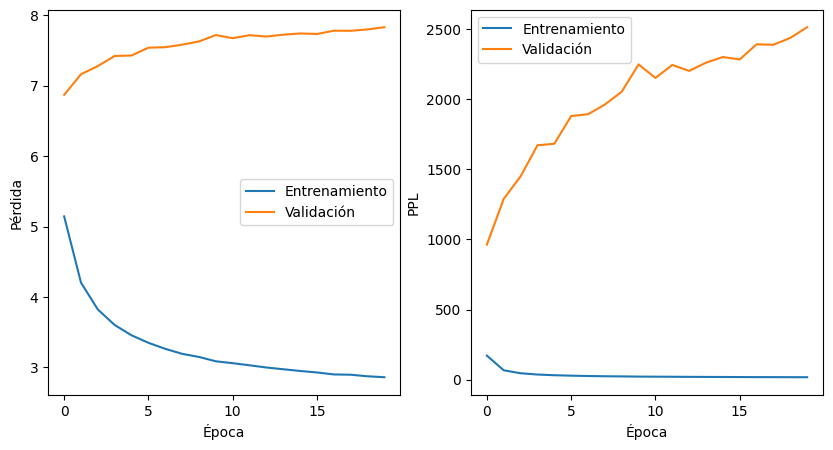

In [44]:
f,axs = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axs[0].plot(save_trn_loss, label='Entrenamiento')
axs[0].plot(save_val_loss, label='Validación')
axs[0].set_xlabel('Época')
axs[0].set_ylabel('Pérdida')
axs[0].legend()

axs[1].plot(save_trn_PPL, label='Entrenamiento')
axs[1].plot(save_val_PPL, label='Validación')
axs[1].set_xlabel('Época')
axs[1].set_ylabel('PPL')
axs[1].legend()
plt.show()

## Inferencia

In [45]:
model = Seq2Seq(enc, dec, device).to(device)
#PATH = "my_checkpoint.pth.tar"
PATH  = 'model_trn.pt'
checkpoint = torch.load(PATH)
model.load_state_dict(checkpoint)
model.eval()

Seq2Seq(
  (encoder): RNNEncoder(
    (embedding): Embedding(10837, 512)
    (rnn): GRU(512, 512, num_layers=2, dropout=0.5)
  )
  (decoder): RNNDecoder(
    (embedding): Embedding(11509, 512)
    (rnn): GRU(1024, 512, num_layers=2, dropout=0.5)
    (linear): Linear(in_features=512, out_features=11509, bias=True)
  )
)

In [46]:
src_trn, inp_test_trn, label_test_trn = next(iter(dl_trn))
src_val, inp_test_val, label_test_val = next(iter(dl_val))

In [47]:
text_src_test = ds_train.en_vocab.lookup_tokens(src_trn.T[0].tolist())
print(text_src_test)

['A', 'black', 'and', 'white', 'dog', 'is', 'running', 'in', 'the', 'grass', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


## Greedy Search

<img src="https://kikaben.com/beam-search-for-machine-translation/images/greedy-decoding.png">

Imagen tomada de: https://kikaben.com/beam-search-for-machine-translation/

In [48]:
text_src_test = ds_train.en_vocab.lookup_tokens(src_trn.T[0].tolist())
print(text_src_test)

['A', 'black', 'and', 'white', 'dog', 'is', 'running', 'in', 'the', 'grass', '.', '<eos>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>', '<pad>']


In [49]:
translate = translate_sentence(text_src_test,ds_train.en_vocab, ds_train.fr_vocab, model, device)
print(translate)

['chien', 'et', 'blanc', 'dans', 'herbe', '<eos>']


## Beam Search

En este ejemplo se tiene un beam_size=3.

<img src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*SNO2jyh7brFe_Ugz1iC4xg.png">


Sequence 1 — the last global war — (0.35 * 0.4 * 0.1 * 0.21) = 0.0029

Sequence 2 — the second war was — (0.35 * 0.2 * 0.25 * 0.2) =0.0034

Sequence 3 — the war was the — (0.35 * 0.1 * 0.15 * 0.17) = 0.00089


Imagen tomada de: https://medium.com/@jessica_lopez/understanding-greedy-search-and-beam-search-98c1e3cd821d